In [1]:
import json
import os
from matplotlib import pyplot as plt

In [2]:
import json
import os
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random
import json
from PIL import Image
import shutil

def get_anns_in_box(box, anns):
    b_anns = []
    
    # Get image coordinates
    i_x1 = box[0]
    i_y1 = box[1]
    i_x2 = i_x1 + box[2]
    i_y2 = i_y1 + box[3]
    
    # Check each individual annotation
    for a in anns:
        b = a['bbox']
        x1 = b[0]
        y1 = b[1]
        x2 = x1 + b[2]
        y2 = y1 + b[3]
        
        # Annotations will be assigned by centerpoint
        xc = (x1 + x2)/2
        yc = (y1 + y2)/2
        
        # Check if centerpoint is within chip
        if xc > i_x1 and xc < i_x2 and yc > i_y1 and yc < i_y2:
            # adjust coordinates to this chip
            n_x1 = x1 - i_x1
            n_y1 = y1 - i_y1
            n_x2 = n_x1 + b[2]
            n_y2 = n_y1 + b[3]
            
            # Ensure this new annotation is fully on-chip
            if n_x1 < 0:
                n_x1 = 0
            if n_y1 < 0:
                n_y1 = 0
            if n_x2 > i_x2:
                n_x2 = i_x2
            if n_y2 > i_y2:
                n_y2 = i_y2
            
            # Calculate new width and height after key checks
            n_w = n_x2 - n_x1
            n_h = n_y2 - n_y1
            
            new_a = a.copy()
            new_a['bbox'] = [n_x1, n_y1, n_w, n_h]
            
            b_anns.append(new_a)
    return b_anns 

def show_chip_anns(img, anns, gt_path):
    '''
    IN:
        -img: pixels of image chip to be displayed
        -anns: annotations relative to this image
    OUT: display of that chip and annotations
    '''
    # Get Color palette
    pal = make_palette(gt_path)
    
    # Show image on figure
    plt.figure()
    f,ax = plt.subplots(1, figsize = (10,10))
    plt.imshow(img)
    
    # Add annotations
    for a in anns:
        b = a['bbox']
        cat = a['category_id']
        cat_name = get_category_gt(cat, gt_path)
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none")
        plt.text(b[0], b[1], cat_name, ha = "left", color = 'w')
        ax.add_patch(rect)
    plt.show()
    return

def get_im_ids(gt_json):
    '''
    IN: gt coco json file
    OUT: list of all int image ids in that file
    '''
    im_ids = []
    
    # Open file
    with open(gt_json, 'r') as f:
        gt = json.load(f)
        
    images = gt['images']
    
    # Gather image id from every image
    for i in images:
        im_ids.append(i['id'])
    
    # Double check that it is unique
    im_ids = list(set(im_ids))
    
    return im_ids


def get_category_gt(i, gt):
    '''
    IN: 
        -i: int of 'category_id' you would like identified
        -categories: 'categories' section of coco json
    OUT: 
        -name of object category, or "none" if the category isn't present
    '''
    with open(gt, 'r') as f:
        gt = json.load(f)
        
    categories = gt['categories']
    
    for c in categories:
        if c['id'] == i:
            return c['name']
    return "None"

def make_palette(gt):
    # Open gt file
    with open(gt, 'r') as f:
        contents = json.load(f)
    
    categories = contents['categories']
    
    palette = sns.hls_palette(len(categories))
        
    return palette

def get_category(i, categories):
    '''
    IN: 
        -i: int of 'category_id' you would like identified
        -categories: 'categories' section of coco json
    OUT: 
        -name of object category, or "none" if the category isn't present
    '''
    for c in categories:
        if c['id'] == i:
            return c['name']
    return "None"
        
def get_category_counts(json_path):
    '''
    IN: json_path: path to coco json gt file
    OUT: dict of form {category name: count of objects}
    '''
    # Open json file
    with open(json_path, 'r') as f:
        contents = json.load(f)
    
    # Pull out key sections
    anns = contents['annotations']
    cats = contents['categories']

    # Create dictionary of by-class counts
    cat_counts = {}
    for a in anns:
        cat = a['category_id']
        name = get_category(cat, cats)
        if name not in cat_counts:
            cat_counts[name] = 1
        else:
            cat_counts[name] = cat_counts[name] + 1
    
    return cat_counts


def json_fewer_cats(old_json, cat_list, ims_no_anns = False, renumber_cats = True):
    '''
    PURPOSE: Create a json with a subset of object categories
    IN:
        -old_json: gt coco json
        -cat_list: list of int category ids to be included in new coco gt json
        -ims_no_anns: if False (default), remove images without annotations from 'images', else keep all original images
    OUT: (new_name) path to new json file 
    '''
    # Name new json by the number of categories being included
    new_name = old_json.replace('.', '_{}.'.format(len(cat_list)))
    
    # Open original gt json
    with open(old_json, 'r') as f:
        contents = json.load(f)
        
    # Pull out key sections of old gt 
    annotations = contents['annotations']
    images = contents['images']
    cats = contents['categories']
    
    # Create new json, with blank annotations
    new_json = contents.copy()
    new_json['annotations'] = []
    
    # Feedback
    print(len(annotations), 'annotations found')
    
    # Process annotations, keeping only those which are in the desired categories
    count = 0
    for a in annotations:
        cat_id = a['category_id']
        if cat_id in cat_list:
            new_json['annotations'].append(a)
        count += 1
    
    # If desired, only keep images that have annotations on them
    if not ims_no_anns:
        new_json['images'] = []
        print(len(images), "images in original data")
        # Check each image for annotations
        for i in images:
            anns = []
            im_id = i['id']
            for a in new_json['annotations']:
                if a['image_id'] == im_id:
                    anns.append(a)
            if len(anns) > 1:
                new_json['images'].append(i)
        print(len(new_json['images']), "images in new data")
    
    # If desired, make sure that categories are sequentially numbered
    if renumber_cats:
        final_annotations = []
        cat_id = 1
        new_cats = []
        for cat in cats:
            old_id = cat['id']
            if old_id in cat_list:
                new_cat = cat.copy()
                
                for a in new_json['annotations']:
                    if a['category_id'] == old_id:
                        new_ann = a.copy()
                        new_ann['category_id'] = cat_id
                        final_annotations.append(new_ann)
                
                new_cat['id'] = cat_id
                cat_id += 1
                new_cats.append(new_cat)
        new_json['annotations'] = final_annotations
        
    new_json['categories'] = new_cats
    
    
    # Feedback
    print(len(new_json['annotations']), 'annotations in new file at', new_name)
    
    # Ensure no .json funny business will happen
    if os.path.exists(new_name):
        os.remove(new_name)
    
    # Save new file
    with open(new_name, 'w') as f:
        json.dump(new_json, f)
    
    return new_name

def anns_on_image(im_id, json_path):
    '''
    IN: 
        - im_id: int id for 'id' in 'images' of coco json
        - json_path: path to coco gt json
    OUT:
        - on_image: list of annotations on the given image
    '''
    # Open json
    with open(json_path, 'r') as f:
        contents = json.load(f)
    
    # Pull out annotations
    anns = contents['annotations']
    
    # Create list of anns on this image
    on_image = []
    for a in anns:
        if a['image_id'] == im_id:
            on_image.append(a)
    
    return on_image

def anns_on_image_dt(im_id, json_path):
    '''
    IN: 
        - im_id: int id for 'id' in 'images' of coco json
        - json_path: path to coco gt json
    OUT:
        - on_image: list of annotations on the given image
    '''
    # Open json
    with open(json_path, 'r') as f:
        contents = json.load(f)
    
    # Create list of anns on this image
    on_image = []
    for a in contents:
        if a['image_id'] == im_id:
            on_image.append(a)
    
    return on_image

def choose_random_ims(num_ims, json_path):
    '''
    IN:
        -num_ims: int number of image ids desired
        -json_path: path to gt coco json
    OUT:
        -list of num_ims random image ids from the input json
    '''
    # Open json
    with open(json_path, 'r') as f:
        contents = json.load(f)
    
    # Pull out key section
    images = contents['images']
    
    # Get a list of all image ids in the json
    all_ims = []
    for i in images:
        all_ims.append(i['id'])
    
    # Enusre there are no duplicates in the list
    all_ims = list(set(all_ims))
    
    # Shuffle the list
    random.shuffle(all_ims)
    
    # Create a smaller list of the num_ims requested
    rand_ims = all_ims[:num_ims]
    
    return rand_ims

def display_random_ims(num_ims, json_path, image_folder, fig_size = (20,20)):
    '''
    PURPOSE: Display some number of images from a coco dataset, randomly selected
    IN:
        -num_ims: int indicating how many to display
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''
    # Get Color palette
    pal = make_palette(json_path)
    
    # Pick the image ids to display
    ims = choose_random_ims(num_ims, json_path)
    
    with open(json_path, 'r') as f:
        gt = json.load(f)
        
    # Process each image
    for i in ims:
        
        images = gt['images']
        for im in images:
            if im['id'] == i:
                im_name = im['file_name']
        
        # Get annotations on this image
        anns = anns_on_image(i, json_path)
        
        # Display the image
        im_path = image_folder + im_name
        plt.figure()
        f,ax = plt.subplots(1, figsize = fig_size)
        img = plt.imread(im_path)
        plt.imshow(img)
        for a in anns:
            b = a['bbox']
            cat = a['category_id']
            cat_name = get_category_gt(cat, json_path)
            rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none")
            plt.text(b[0], b[1], cat_name, ha = "left", color = 'w')
            ax.add_patch(rect)
        plt.show()
    
    return

def display_im_anns(im_id, json_path, image_folder, fig_size = (20,20)):
    '''
    PURPOSE: Display some image with annotations from coco dataset
    IN:
        -im_id: int id of image from coco 'images' section
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''
   
    # Get annotations on this image
    anns = anns_on_image(im_id, json_path)
    
    with open(json_path, 'r') as f:
        gt = json.load(f)
        
    images = gt['images']
    for im in images:
        if im['id'] == im_id:
            im_name = im['file_name']

    # Display the image
    im_path = image_folder + im_name
    plt.figure()
    f,ax = plt.subplots(1, figsize = fig_size)
    img = plt.imread(im_path)
    plt.imshow(img)
    for a in anns:
        b = a['bbox']
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = 'r', facecolor = "none")
        ax.add_patch(rect)
    plt.show()
    
    return

def show_im_chips(im_id, gt, size):
    im_anns = anns_on_image(im_id, gt)

    im_name = images + str(im_id) + '.tif'
    img = plt.imread(im_name)

    (y,x,c) = img.shape

    num_x = int(x/size)
    num_y = int(y/size)

    chip_num = 0

    for x_i in range(num_x):
        for y_i in range(num_y):
            c_x1 = x_i * size
            c_y1 = y_i * size
            bbox = [c_y1, c_x1, size, size]
            anns = get_anns_in_box(bbox, im_anns)
            if len(anns) > 0:
                chip_name = str(chip_num) + '_' + str(im_id) + '_{}_{}_{}_{}'.format(c_x1, c_y1, size, size) + '.tif'
                chip_num += 1
                image_chip = img[c_x1:c_x1 + size, c_y1:c_y1 + size]
                show_chip_anns(image_chip, anns, gt)
    
    return

def subchip_images(gt, image_folder, new_image_folder, chip_size):
    '''
    Purpose: Take a coco style json and associated image folder, 
    and create a new coco json and image folder containing new images 
    of the specified size
    '''
    
    # Open gt json
    with open(gt, 'r') as f:
        gt_og = json.load(f)
    
    # New data
    new_images = []
    new_anns = []
    
    # Create new save locations
    gt_new_path = gt.replace('.', '_{}.'.format(chip_size))
   
    if not os.path.exists(new_image_folder):
        os.mkdir(new_image_folder)
    
    chip_num = 0
    
    # Iterate through data one image at a time
    image_ids = get_im_ids(gt)
    images_processed = 0
    for im_id in image_ids:
        # Get all original annotations on this image
        im_anns = anns_on_image(im_id, gt)
        
        # Open the image
        im_name = image_folder + str(im_id) + '.tif'
        if os.path.exists(im_name):
            img = plt.imread(im_name)
            
            grayscale = False
            if len(img.shape) == 2:
                grayscale = True
        
            
            # Get image dimensions
            (x,y,c) = img.shape
            num_x = int(x/chip_size)
            num_y = int(y/chip_size)
            
            # Process each individual chip on this image
            for x_i in range(num_x):
                for y_i in range(num_y):
                    
                    # Get chip coords
                    c_x1 = x_i * chip_size
                    c_y1 = y_i * chip_size
                    bbox = [c_y1, c_x1, chip_size, chip_size]
                    
                    # If there are annotations on this image, save out a chip
                    anns = get_anns_in_box(bbox, im_anns)
                    if len(anns) > 0:
                        chip_name = str(chip_num) + '_' + str(im_id) + '_{}_{}_{}_{}'.format(c_x1, c_y1, chip_size, chip_size) + '.png'
                        chip_path = new_image_folder + chip_name
                        
                        # Update image annotation
                        new_image = {
                            'file_name' : chip_name,
                            'width' : chip_size,
                            'height' : chip_size,
                            'id' : chip_num,
                            'license' : 1
                        }
                        new_images.append(new_image)
                        
                        # Update object annotations
                        for a in anns:
                            new_a = a.copy()
                            new_a['image_id'] = chip_num
                            new_anns.append(new_a)
                        
                        
                        chip_num += 1
                        image_chip = img[c_x1:c_x1 + chip_size, c_y1:c_y1 + chip_size]
                        
                        if not os.path.exists(chip_path):
                            try:
                                if grayscale:
                                    plt.imsave(chip_path, image_chip, cmap = 'gray')
                                else:
                                    plt.imsave(chip_path, image_chip)
                            except:
                                continue
                            
            images_processed += 1
            if images_processed % 50 == 0:
                print(images_processed, "images processed")
        
    # Save out new gt file
    new_gt = gt_og.copy()
    new_gt['images'] = new_images
    new_gt['annotations'] = new_anns
    
    if os.path.exists(gt_new_path):
        os.remove(gt_new_path)
    
    with open(gt_new_path, 'w') as f:
        json.dump(new_gt, f)
        
    print('New ground truth:', gt_new_path)
    print('New images:', new_image_folder)
    
    return

def find_im_path(im_id, image_paths):
    
    for i in image_paths:
        image = i.split('/')[-1]
        im_num = int(image.split('.')[0])
        if im_num == im_id:
            return i
    
    return "None"

def get_image_paths(image_folder):
    # Image paths
    folders = os.listdir(image_folder)
    folders = [image_folder + f + '/' for f in folders]
    image_paths = []
    for f in folders:
        images = os.listdir(f)
        images = [f + i for i in images]
        image_paths.extend(images)
    
    return image_paths

def subchip_images_colab(gt, image_folder, new_image_folder, chip_size):
    '''
    Purpose: Take a coco style json and associated image folder of image folders, 
    and create a new coco json and image folder containing new images 
    of the specified size
    '''
    
    # Open gt json
    with open(gt, 'r') as f:
        gt_og = json.load(f)
    
    # New data
    new_images = []
    new_anns = []
    
    # Create new save locations
    gt_new_path = gt.replace('.', '_{}.'.format(chip_size))
   
    if not os.path.exists(new_image_folder):
        os.mkdir(new_image_folder)
        
    # Get paths to all available images in sub-folders
    image_paths = get_image_paths(image_folder)    
    print(len(image_paths), 'images discovered in folders')
    
    chip_num = 0
    
    # Iterate through data one image at a time
    image_ids = get_im_ids(gt)
    images_processed = 0
    for im_id in image_ids:
        # Get all original annotations on this image
        im_anns = anns_on_image(im_id, gt)
        
        # Open the image
        im_name = find_im_path(im_id, image_paths)
        if os.path.exists(im_name):
            img = plt.imread(im_name)
            
            # Get image dimensions
            (x,y,c) = img.shape
            num_x = int(x/chip_size)
            num_y = int(y/chip_size)
            
            # Process each individual chip on this image
            for x_i in range(num_x):
                for y_i in range(num_y):
                    
                    # Get chip coords
                    c_x1 = x_i * chip_size
                    c_y1 = y_i * chip_size
                    bbox = [c_y1, c_x1, chip_size, chip_size]
                    
                    # If there are annotations on this image, save out a chip
                    anns = get_anns_in_box(bbox, im_anns)
                    if len(anns) > 0:
                        chip_name = str(chip_num) + '_' + str(im_id) + '_{}_{}_{}_{}'.format(c_x1, c_y1, chip_size, chip_size) + '.png'
                        chip_path = new_image_folder + chip_name
                        
                        # Update image annotation
                        new_image = {
                            'file_name' : chip_name,
                            'width' : chip_size,
                            'height' : chip_size,
                            'id' : chip_num,
                            'license' : 1
                        }
                        new_images.append(new_image)
                        
                        # Update object annotations
                        for a in anns:
                            new_a = a.copy()
                            new_a['image_id'] = chip_num
                            new_anns.append(new_a)
                        
                        
                        chip_num += 1
                        image_chip = img[c_x1:c_x1 + chip_size, c_y1:c_y1 + chip_size]
                        image_chip = Image.fromarray(image_chip).convert('RGB')
                        
                        if not os.path.exists(chip_path):
                            try:
                                image_chip.save(chip_path)
                            except:
                                continue
                            
            images_processed += 1
            if images_processed % 50 == 0:
                print(images_processed, "images processed")
        
    # Save out new gt file
    new_gt = gt_og.copy()
    new_gt['images'] = new_images
    new_gt['annotations'] = new_anns
    
    if os.path.exists(gt_new_path):
        os.remove(gt_new_path)
    
    with open(gt_new_path, 'w') as f:
        json.dump(new_gt, f)
        
    print('New ground truth:', gt_new_path)
    print('New images:', new_image_folder)
    
    return gt_new_path

def convert_imgs_rgb(folder):
    '''
    Purpose: force all images in folder to assume kosher image format
    '''
    test_images = os.listdir(folder)
    test_images = [folder + i for i in test_images]
    count  = 0
    for i in test_images:   
        img = Image.open(i).convert('RGB')
        img.save(i)
        count += 1
        if count % 250 == 0:
            print(count)
    
    return

def gt_from_im_folder(full_gt, img_folder, new_gt_path):
    # Read in full gt
    with open(full_gt, 'r') as f:
        gt = json.load(f)

    # Initialize key storage containers
    contents = gt.copy()
    contents['images'] = []
    contents['annotations'] = []
    images = []
    annotations = []

    # Process one image at a time
    ims = os.listdir(img_folder)

    for image in ims:
        i = int(image.split('_')[0])
        anns = anns_on_image(i, full_gt) 
        annotations.extend(anns)
        for im_info in gt['images']:
            if im_info['id'] == i:
                images.append(im_info)

    # Load new data into appropriate format and save
    contents['images'] = images
    contents['annotations'] = annotations

    if os.path.exists(new_gt_path):
        os.remove(new_gt_path)

    with open(new_gt_path, 'w') as f:
        json.dump(contents, f)

    return

def gt_from_im_list(full_gt, img_list, new_gt_path):
    # Read in full gt
    with open(full_gt, 'r') as f:
        gt = json.load(f)

    # Initialize key storage containers
    contents = gt.copy()
    contents['images'] = []
    contents['annotations'] = []
    images = []
    annotations = []

    # Process one image at a time
    for image in img_list:
        i = int(image.split('_')[0].replace('maksssksksss', '').split('.')[0])
        anns = anns_on_image(i, full_gt) 
        annotations.extend(anns)
        for im_info in gt['images']:
            if im_info['id'] == i:
                images.append(im_info)

    # Load new data into appropriate format and save
    contents['images'] = images
    contents['annotations'] = annotations

    if os.path.exists(new_gt_path):
        os.remove(new_gt_path)

    with open(new_gt_path, 'w') as f:
        json.dump(contents, f)

    return

def test_train_split(chip_folder, test_percentage, gt, chip_size):
    
    all_chips = os.listdir(chip_folder)

    random.shuffle(all_chips)
    num_chips = len(all_chips)
    print("Num chips", num_chips)

    test_ind = int(num_chips*test_percentage)
    print("Test_ind", test_ind)

    # Select images for test and train
    test_chips = all_chips[:test_ind]
    train_chips = all_chips[test_ind:]
    
    # Make new gt
    train_data_name = 'train_' + str(chip_size) + '_gt.json'
    test_data_name = 'test_' + str(chip_size) + '_gt.json'
    gt_from_im_list(gt, train_chips, train_data_name)
    gt_from_im_list(gt, test_chips, test_data_name)


    print(train_data_name, test_data_name)
    return train_data_name, test_data_name

def json_images(gt_json_path):
    '''
    Purpose: return a list of image paths in a specified json
    '''
    with open(gt_json_path, 'r') as f:
        gt = json.load(f)
    
    images = gt['images']
    im_paths = []
    for i in images:
        im_paths.append(i['file_name'])

    return im_paths

def check_for_parity(train_gt_path, test_gt_path, chip_dir):
    '''
    Purpose: determine if all the images in a defined train/test split
    exist within a specified folder
    '''
    # Get a list of all chips in the split
    test_ims = json_images(test_gt_path)
    train_ims = json_images(train_gt_path)

    former_ims = test_ims.copy()
    former_ims.extend(train_ims)

    # List of images in the folder
    new_ims = os.listdir(chip_dir)

    # Check if all images in split are in folder
    # And all ims in folder are in split
    they_match = True

    for i in new_ims:
        if i not in former_ims:
            they_match = False

    for i in former_ims:
        if i not in new_ims:
            they_match = False

    # Print results
    if they_match:
        print("Images in these jsons and the specified folder match")
    else:
        print("These images don't quite match. Sad.")
                     
    return they_match

def load_test_train_split(test_gt, image_folder):
    test_ims = json_images(test_gt)

    test_folder = image_folder.replace('train', 'test')

    if not os.path.exists(test_folder):
        os.mkdir(test_folder)

    for i in test_ims:
        dst = test_folder + i
        src = image_folder + i

        shutil.move(src, dst)

    return

def random_ims_gt(num_ims, json_path, image_folder, fig_size = (10,10)):
    '''
    PURPOSE: Display some number of images from a coco dataset, randomly selected
    IN:
        -num_ims: int indicating how many to display
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''
    # Get Color palette
    pal = make_palette(json_path)
    
    # Pick the image ids to display
    images = os.listdir(image_folder)
    images = [int(i.split('_')[0]) for i in images]
    random.shuffle(images)
    ims = images[:num_ims]
    
    with open(json_path, 'r') as f:
        gt = json.load(f)
        
    # Process each image
    for i in ims:
        images = gt['images']
        for im in images:
            if im['id'] == i:
                im_name = im['file_name']
        
        # Get annotations on this image
        anns = anns_on_image(i, json_path)
        
        # Display the image
        im_path = image_folder + im_name
        plt.figure()
        f,ax = plt.subplots(1, figsize = fig_size)
        img = plt.imread(im_path)
        plt.imshow(img)
        for a in anns:
            b = a['bbox']
            cat = a['category_id']
            cat_name = get_category_gt(cat, json_path)
            rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none")
            plt.text(b[0], b[1], cat_name, ha = "left", color = 'w')
            ax.add_patch(rect)
        plt.show()
    
    return

def display_random_gt_dt(num_ims, gt_path, dt_path, image_folder, fig_size = (20,20), conf_thresh = 0.9):
    '''
    PURPOSE: Display some number of images from a coco dataset, randomly selected
    IN:
        -num_ims: int indicating how many to display
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''
    # Get Color palette
    pal = make_palette(gt_path)
    
    # Pick the image ids to display
    ims = choose_random_ims(num_ims, gt_path)
    
    with open(dt_path, 'r') as f:
        gt = json.load(f)
        
    # Process each image
    for i in ims:
        
        images = gt['images']
        for im in images:
            if im['id'] == i:
                im_name = im['file_name']
        
        # Get annotations on this image
        anns_dt = anns_on_image_dt(i, dt_path)
        
        # Display the image
        im_path = image_folder + im_name
        plt.figure()
        f,ax = plt.subplots(1, figsize = fig_size)
        img = plt.imread(im_path)
        plt.imshow(img)
        for a in anns_dt:
            b = a['bbox']
            cat = a['category_id']
            conf = a['score']
            if conf >= conf_thresh:
                cat_name = get_category_gt(cat, gt_path)
                rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none", ls = '--')
                #plt.text(b[0], b[1], cat_name, ha = "left", color = 'w')
                ax.add_patch(rect)
        plt.show()
    
    return

def display_random_dt(num_ims, gt_path, dt_path, image_folder, fig_size = (20,20), conf_thresh = 0.9):
    '''
    PURPOSE: Display some number of images from a coco dataset, randomly selected
    IN:
        -num_ims: int indicating how many to display
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''
    # Get Color palette
    pal = make_palette(gt_path)
    
    # Pick the image ids to display
    ims = choose_random_ims(num_ims, gt_path)
    
    with open(gt_path, 'r') as f:
        gt = json.load(f)
        
    # Process each image
    for i in ims:
        
        images = gt['images']
        for im in images:
            if im['id'] == i:
                im_name = im['file_name']
        
        # Get annotations on this image
        anns_dt = anns_on_image_dt(i, dt_path)
        
        # Display the image
        im_path = image_folder + im_name
        plt.figure()
        f,ax = plt.subplots(1, figsize = fig_size)
        img = plt.imread(im_path)
        plt.imshow(img)
        for a in anns_dt:
            b = a['bbox']
            cat = a['category_id']
            conf = a['score']
            if conf >= conf_thresh:
                cat_name = get_category_gt(cat, gt_path)
                rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none", ls = '--')
                plt.text(b[0], b[1], cat_name, ha = "left", color = 'w')
                ax.add_patch(rect)
        plt.show()
    
    return  

def train_val_test_split(image_folder, gt, val_precentage = 0.1, test_percentage = 0.2, data_tag = ""):
    
    data_folder = '/'.join(image_folder.split('/')[:-2]) + '/'

    all_images = os.listdir(image_folder)

    random.shuffle(all_images)
    num_images = len(all_images)
    print("Num images", num_images)

    test_ind = int(num_images*test_percentage)
    val_ind = int(num_images*val_precentage) + test_ind

    # Select images for test and train
    test_images = all_images[:test_ind]
    val_images = all_images[test_ind:val_ind]
    train_images = all_images[val_ind:]
    
    # Make new gt
    train_data_name = data_folder + 'train_' + data_tag + '_gt.json'
    val_data_name = data_folder + 'val_' + data_tag + '_gt.json'
    test_data_name = data_folder + 'test_' + data_tag + '_gt.json'

    # Create new gt files
    gt_from_im_list(gt, train_images, train_data_name)
    gt_from_im_list(gt, val_images, val_data_name)
    gt_from_im_list(gt, test_images, test_data_name)
    print('gt created')
    
    # Create new image folders
    train_folder = data_folder + 'train_images/'
    val_folder = data_folder + 'val_images/'
    test_folder = data_folder + 'test_images/'

    # Move all image files as appropriate
    os.mkdir(val_folder)
    os.mkdir(test_folder)

    for i in val_images:
        src = image_folder + i
        dst = val_folder + i
        shutil.move(src, dst)
    
    for i in test_images:
        src = image_folder + i
        dst = test_folder + i
        shutil.move(src, dst) 

    os.rename(image_folder, train_folder)      

    return data_folder 


In [3]:
def get_im_name(im_id, gt):
    with open(gt, 'r') as f:
        data = json.load(f)
    images = data['images']
    for i in images:
        if i['id'] == im_id:
            return i['file_name']
    return None

In [4]:
def subchip_images(gt, image_folder, new_image_folder, chip_size):
    '''
    Purpose: Take a coco style json and associated image folder, 
    and create a new coco json and image folder containing new images 
    of the specified size
    '''
    
    # Open gt json
    with open(gt, 'r') as f:
        gt_og = json.load(f)
    
    # New data
    new_images = []
    new_anns = []
    
    # Create new save locations
    gt_new_path = gt.replace('.', '_{}.'.format(chip_size))
   
    if not os.path.exists(new_image_folder):
        os.mkdir(new_image_folder)
    
    chip_num = 0
    
    # Iterate through data one image at a time
    image_ids = get_im_ids(gt)
    images_processed = 0
    for im_id in image_ids:
        # Get all original annotations on this image
        im_anns = anns_on_image(im_id, gt)

        # Open the image
        im_name = image_folder + get_im_name(im_id, gt)
        if os.path.exists(im_name):
            img = plt.imread(im_name)
            
            grayscale = False
            if len(img.shape) == 2:
                grayscale = True

            # Get image dimensions
            h = img.shape[0]
            w = img.shape[1]

            num_x = int(w/chip_size) + 1
            num_y = int(h/chip_size) + 1

            im_chip_x = int(w/num_x)
            im_chip_y = int(h/num_y)

            # Process each individual chip on this image
            for x_i in range(num_x):
                for y_i in range(num_y):

                    # Get chip coords
                    c_x1 = x_i * im_chip_x
                    c_y1 = y_i * im_chip_y

                    bbox = [c_x1, c_y1, im_chip_x, im_chip_y]

                    # If there are annotations on this image, save out a chip
                    anns = get_anns_in_box(bbox, im_anns)
                    if len(anns) > 0:
                        chip_name = str(chip_num) + '_' + str(im_id) + '_{}_{}_{}_{}'.format(c_x1, c_y1, im_chip_x, im_chip_y) + '.png'
                        chip_path = new_image_folder + chip_name

                        # Update image annotation
                        new_image = {
                            'file_name' : chip_name,
                            'width' : im_chip_x,
                            'height' : im_chip_y,
                            'id' : chip_num,
                            'license' : 1
                        }
                        new_images.append(new_image)

                        # Update object annotations
                        for a in anns:
                            new_a = a.copy()
                            new_a['image_id'] = chip_num
                            new_anns.append(new_a)


                        chip_num += 1
                        image_chip = img[c_y1:c_y1 + im_chip_y, c_x1:c_x1 + im_chip_x]

                        if not os.path.exists(chip_path):
                            try:
                                if grayscale:
                                    plt.imsave(chip_path, image_chip, cmap = 'gray')
                                else:
                                    plt.imsave(chip_path, image_chip)

                            except:
                                print(f'Problem chip {chip_path}')
                                continue
                            
            images_processed += 1
            if images_processed % 50 == 0:
                print(images_processed, "images processed")
        
    # Save out new gt file
    new_gt = gt_og.copy()
    new_gt['images'] = new_images
    new_gt['annotations'] = new_anns
    
    if os.path.exists(gt_new_path):
        os.remove(gt_new_path)
    
    with open(gt_new_path, 'w') as f:
        json.dump(new_gt, f)
        
    print('New ground truth:', gt_new_path)
    print('New images:', new_image_folder)
    
    return

In [6]:
cwd = 'C:/Users/knjoh/Documents/DOTA/train/'

In [7]:
gt = cwd + 'COCO.json'
image_folder = cwd + 'images/'
new_image_folder = cwd + 'images_1000/'
chip_size = 1000

In [8]:
subchip_images(gt, image_folder, new_image_folder, chip_size)

50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
350 images processed
400 images processed
450 images processed
500 images processed
550 images processed
600 images processed
650 images processed
700 images processed
750 images processed
800 images processed
850 images processed
900 images processed
950 images processed
1000 images processed
1050 images processed
1100 images processed
1150 images processed
1200 images processed
1250 images processed
1300 images processed
1350 images processed
1400 images processed
New ground truth: C:/Users/knjoh/Documents/DOTA/train/COCO_1000.json
New images: C:/Users/knjoh/Documents/DOTA/train/images_1000/


<Figure size 432x288 with 0 Axes>

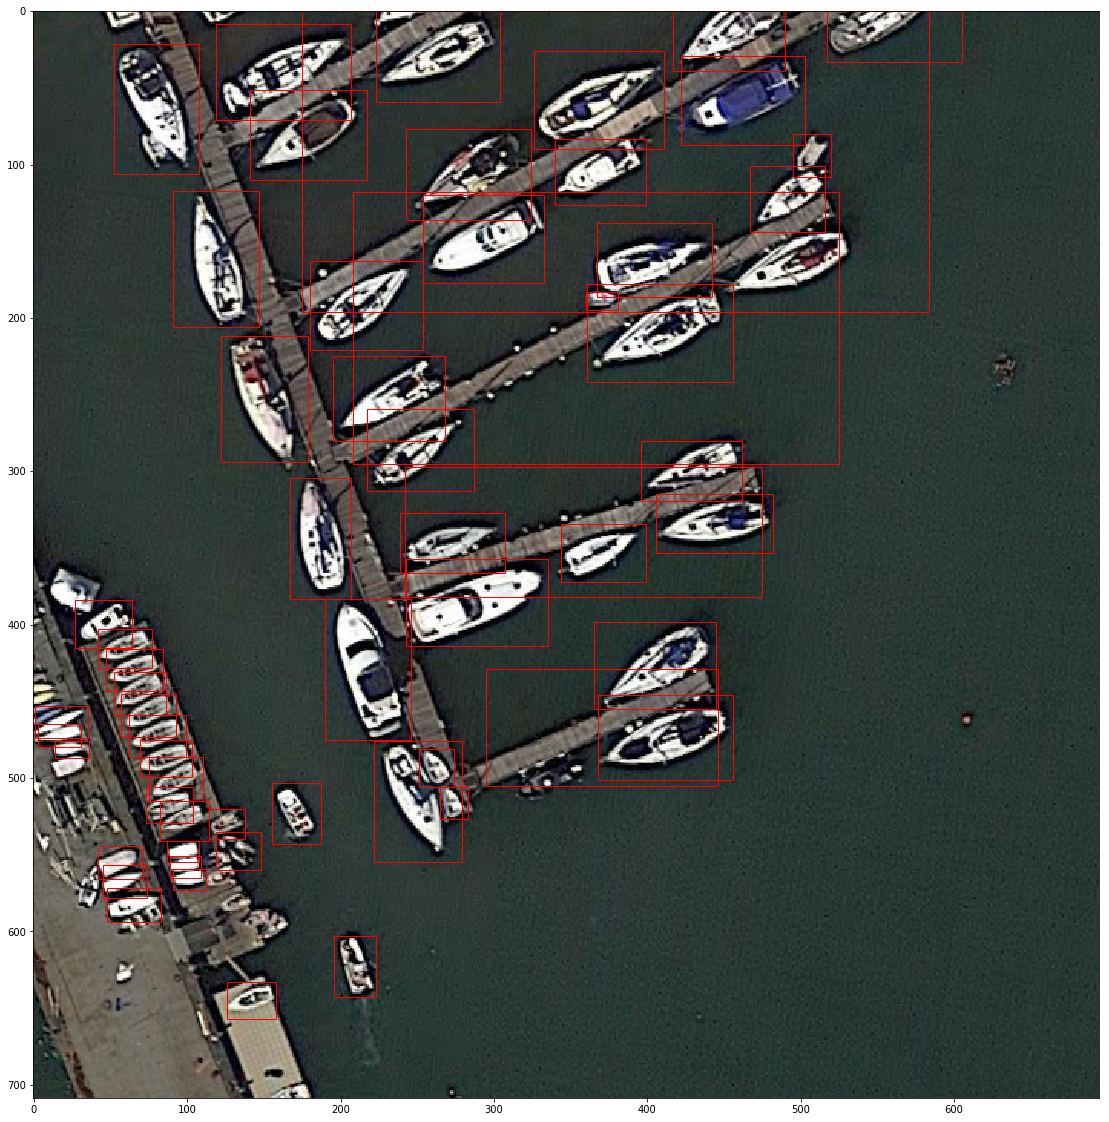

In [10]:
display_im_anns(1730, 'C:/Users/knjoh/Documents/DOTA/train/COCO_1000.json', 'C:/Users/knjoh/Documents/DOTA/train/images_1000/')

In [13]:
def match_categories(template_gt, gt):
    
    with open(template_gt, 'r') as f:
        temp_gt = json.load(f)
    with open(gt, 'r') as f:
        data = json.load(f)
        
    anns = data['annotations']
    new_anns = []
        
    template_cats = temp_gt['categories']
    
    cats = data['categories']
    
    for c in cats:
        cat_name = c['name']
        cat_id = c['id']
        for t in template_cats:
            if t['name'] == cat_name:
                new_cat_id = t['id']
                
                for a in anns:
                    if a['category_id'] == cat_id:
                        new_ann = a.copy()
                        new_ann['category_id'] = new_cat_id
                        new_anns.append(new_ann)
    data['annotations'] = new_anns
    data['categories'] = template_cats

    os.remove(gt)
    
    with open(gt, 'w') as f:
        json.dump(data, f)
    return

In [16]:
val_dir = 'C:/Users/knjoh/Documents/DOTA/val/'
train_dir = 'C:/Users/knjoh/Documents/DOTA/train/'

In [17]:
val_gt = val_dir + 'COCO.json'
val_gt_1000 = val_dir + 'COCO_1000.json'

train_gt = train_dir + 'COCO.json'
train_gt_1000 = train_dir + 'COCO_1000.json'

In [18]:
match_categories(train_gt, train_gt_1000)

In [19]:
match_categories(train_gt, val_gt)
match_categories(train_gt, val_gt_1000)